# Processing and analyzing data from a stationary detector

This tutorial demonstrates how to process and analyze neutron counts of epithermal neutrons recorded with a stationary cosmic-ray neutron probe consisting of three lithium-foil detectors manufactured by Radiation Detection Technologies, Inc (RDT). The tutorial covers all the steps from reading the file with raw data obtained from the probe in the field, outlier removal, atmospheric corrections, and conversion of corrected neutron counts into volumetric soil water content. 

The tutorial assumes that you are working within the `Anaconda` environment, which has all the necessary modules. Also, make sure that the `CRNPy` library is installed in your machine.

The raw dataset to follow this example can be obtained at the [.csv file](https://raw.githubusercontent.com/soilwater/crnpy/main/docs/examples/stationary/rdt.csv).

This device was installed in the vicinity of the KONA site of the National Ecological Observatory Network within the Konza Prairie Biological station (`39.110596, -96.613050, 320 meters a.s.l.`)


In [1]:
# Import required libraries
import crnpy

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [2]:
# Load observations from a stationary detector
filepath = "https://raw.githubusercontent.com/soilwater/crnpy/main/docs/examples/stationary/rdt.csv"

# Read the DataFrame
df = pd.read_csv(filepath, names=['timestamp','barometric_pressure_Avg','relative_humidity_Avg', 'air_temperature_Avg','DP','BattVolt','counts_1_Tot','counts_2_Tot','counts_3_Tot'])

# Parse timestamps
df['timestamp'] = pd.to_datetime(df['timestamp'])

# Display a few rows of the dataset
df.head(3)


,timestamp,barometric_pressure_Avg,relative_humidity_Avg,air_temperature_Avg,DP,BattVolt,counts_1_Tot,counts_2_Tot,counts_3_Tot
0,2020-04-10 09:47:00,983.8,29.0,9.6,-7.4,14.4,848,716.0,742
1,2020-04-10 10:47:00,982.3,25.0,10.9,-7.9,14.3,436,7200.0,796
2,2020-04-10 11:17:00,980.8,25.0,11.5,-7.4,13.7,389,396.0,354


In [3]:
# Remove rows with incomplete intervals
df = crnpy.remove_incomplete_intervals(df, timestamp_col='timestamp', integration_time=3600, remove_first=True)

# Fill missing timestamps to create a conplete record
df = crnpy.fill_missing_timestamps(df, timestamp_col='timestamp', freq='H', round_timestamp=True)


Removed a total of 48 rows.
Added a total of 60 missing timestamps.


Utilize the [`total_raw_counts()`](../../../reference/#crnpy.crnpy.total_raw_counts) function to calculate the total counts across all detectors. After calculating the total counts, identify outliers using the [`is_outlier()`](../../../reference/#crnpy.crnpy.is_outlier) function.

In [4]:
# Flag and fill outliers
cols_counts = ['counts_1_Tot','counts_2_Tot','counts_3_Tot']
for col in cols_counts:
    
    # Find outliers
    idx_outliers = crnpy.is_outlier(df[col], method='scaled_mad', min_val=500, max_val=2000)
    df.loc[idx_outliers,col] = np.nan
    
    # Fill missing values with linear interpolation and round to nearest integer
    df[col] = df[col].interpolate(method='linear', limit=3, limit_direction='both').round()


In [5]:
# Compute total cunts
df['total_raw_counts'] = crnpy.total_raw_counts(df[cols_counts], nan_strategy='average')


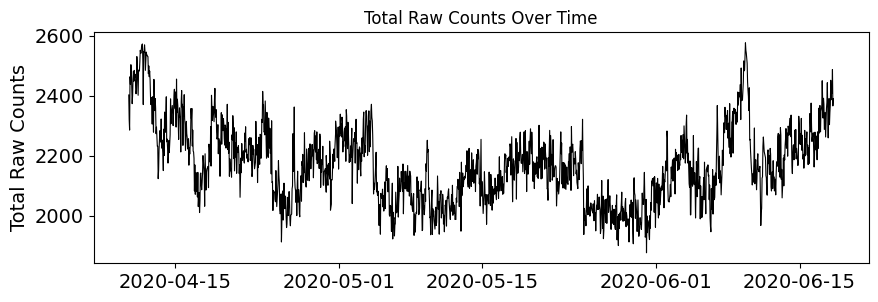

In [6]:
# Plot total counts
# Create a new figure and plot the data
fig, ax = plt.subplots(figsize=(10, 3))  # Set the figure size
ax.plot(df['timestamp'], df['total_raw_counts'], label='Raw Counts', color='black', linewidth=.8)
# Set the labels for the x-axis and y-axis
ax.set_ylabel("Total Raw Counts", fontsize=14)

# Set the title of the plot
ax.set_title('Total Raw Counts Over Time')

# Adjust size of axes labels
ax.tick_params(axis='both', which='major', labelsize=14)

# Show the plot
plt.show()


### Neutron count correction

#### Incomming neutron flux

Find similar neutron monitors based on altitude and cutoff rigidity, which is estimated based on the geographic location using latitude and longitude values. See [`get_incoming_neutron_flux()`](../../../reference/#crnpy.crnpy.get_incoming_neutron_flux), [`find_neutron_monitor()`](../../../reference/#crnpy.crnpy.find_neutron_monitor) and [`correction_incoming_flux()`](../../../reference/#crnpy.crnpy.correction_incoming_flux). 

In this particular example we selected the `"IRKT"` monitor since it has a similar cuoff rigidity and altitude as our site. The reference neutron monitor will likely be different for your location. Note that the function only reports neutron monitors based on cutoff rigidity and leaves to the user the selection of a reference neutron monitor based on the altitude of the location.

In [7]:
# Define study start and end dates
start_date = df.iloc[0]['timestamp']
end_date = df.iloc[-1]['timestamp']

# Define geographic coordiantes
lat = 39.110596
lon = -96.613050

# Find stations with cutoff rigidity similar to estimated by lat,lon
crnpy.find_neutron_monitor(crnpy.cutoff_rigidity(lat, lon), start_date=start_date, end_date=end_date, verbose=False)



Select a station with an altitude similar to that of your location. For more information go to: 'https://www.nmdb.eu/nest/help.php#helpstations

Your cutoff rigidity is 2.87 GV
     STID     NAME     R  Altitude_m  Period available
13   DRBS  Dourbes  3.18         225              True
40   NEWK   Newark  2.40          50              True
28  KIEL2   KielRT  2.36          54              True
21   IRKT  Irkustk  3.64         435              True


,STID,NAME,R,Altitude_m,Period available
13,DRBS,Dourbes,3.18,225,True
40,NEWK,Newark,2.40,50,True
28,KIEL2,KielRT,2.36,54,True
21,IRKT,Irkustk,3.64,435,True


In [8]:
# Download incoming neutron flux data from the Neutron Monitor Database (NMDB).
# Use utc_offset for Central Standard Time.
nmdb = crnpy.get_incoming_neutron_flux(start_date, end_date, station="IRKT", utc_offset=-6)


In [9]:
# Interpolate incoming neutron flux to match the timestamps in our station data
df['incoming_flux'] = crnpy.interpolate_incoming_flux(nmdb['timestamp'], nmdb['counts'], df['timestamp'])


In [10]:
# Compute correction factor for incoming neutron flux
df['fi'] = crnpy.correction_incoming_flux(incoming_neutrons=df['incoming_flux'],
                                          incoming_Ref=df['incoming_flux'].iloc[0])


#### Atmospheric correction

This section is about correcting the atmospheric variables. First, fill the missing values in the atmospheric data, then correct the count for atmospheric variables using [`correction_humidity()`](../../../reference/#crnpy.crnpy.correction_humidity) and [`correction_pressure()`](../../../reference/#crnpy.crnpy.correction_pressure). 

In [11]:
# Fill NaN values in atmospheric data and neutron counts
df[['barometric_pressure_Avg','relative_humidity_Avg', 'air_temperature_Avg']] = df[['barometric_pressure_Avg','relative_humidity_Avg', 'air_temperature_Avg']].interpolate(method='pchip', limit=24, limit_direction='both')

# Compute the pressure correction factor 
df['fp'] = crnpy.correction_pressure(pressure=df['barometric_pressure_Avg'], Pref=df['barometric_pressure_Avg'].mean(), L=130)

# Calculate the absolute humidity (g cm^-3) and the vapor pressure correction factor
df['abs_humidity'] = crnpy.abs_humidity(df['relative_humidity_Avg'], df['air_temperature_Avg'])
df['fw'] = crnpy.correction_humidity(abs_humidity=df['abs_humidity'], Aref=0)


Text(0.5, 1.0, 'Correction Factors for Pressure, Humidity, and Incoming Flux')

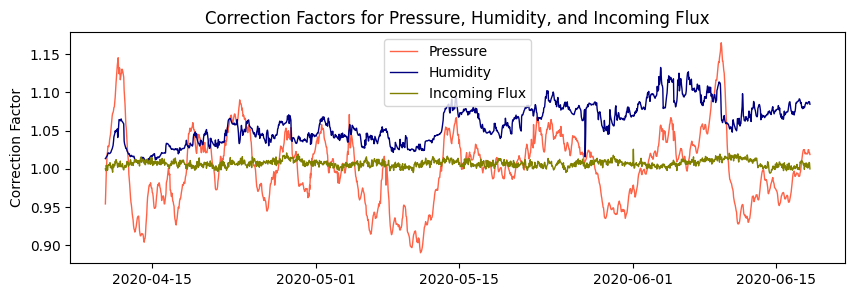

In [12]:
# Plot all the correction factors
fig, ax = plt.subplots(figsize=(10, 3))  # Set the figure size
ax.plot(df['timestamp'], df['fp'], label='Pressure',color='tomato', linewidth=1)
ax.plot(df['timestamp'], df['fw'], label='Humidity', color='navy', linewidth=1)
ax.plot(df['timestamp'], df['fi'], label='Incoming Flux', color='olive', linewidth=1)
ax.set_ylabel('Correction Factor')
ax.legend()
ax.set_title('Correction Factors for Pressure, Humidity, and Incoming Flux')


In [13]:
# Apply correction factors
df['total_corrected_neutrons'] = df['total_raw_counts'] * df['fw'] / (df['fp'] * df['fi'])


Text(0.5, 1.0, 'Raw and Corrected Counts')

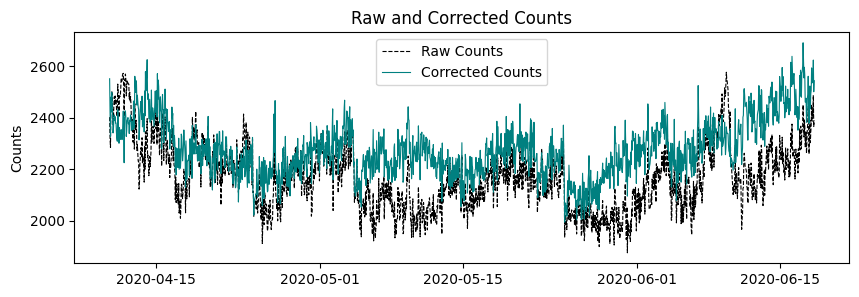

In [14]:
fig, ax = plt.subplots(figsize=(10, 3))  # Set the figure size

# Subplot 1: Raw and Corrected Counts
ax.plot(df['timestamp'], df['total_raw_counts'], label='Raw Counts', color='black', linestyle='dashed', linewidth=.8)
ax.plot(df['timestamp'], df['total_corrected_neutrons'], label='Corrected Counts', color='teal', linewidth=.8)
ax.set_ylabel('Counts')
ax.legend()
ax.set_title('Raw and Corrected Counts')


Convert the smoothed neutron counts to Volumetric Water Content (VWC) using the [`counts_to_vwc()`](../../../reference/#crnpy.crnpy.counts_to_vwc). The function considers the smoothed neutron counts, $N_0$ specific parameter, soil bulk density, weight percent of latent water (Wlat), and weight percent of soil organic carbon (Wsoc). After conversion, plot the VWC against the timestamp for visual analysis. [`smooth_1d()`](../../../reference/#crnpy.crnpy.smooth_1d) is pplied for smothing the data using a Savitzky-Golay filter.



In [15]:
# Device N0 parameter
N0_rdt = 3767 # Patrignani, A., Ochsner, T. E., Montag, B., & Bellinger, S. (2021). A novel lithium foil cosmic-ray neutron detector for measuring field-scale soil moisture. Frontiers in Water, 3, 673185.

# Estimate lattice water (%) based on texture
lattice_water = crnpy.lattice_water(clay_content=0.35)

df['VWC'] = crnpy.counts_to_vwc(df['total_corrected_neutrons'], N0=N0_rdt, bulk_density=1.33, Wlat=lattice_water, Wsoc=0.01)

# Drop any NaN beofre smoothing
df = df.dropna(subset=['VWC']).copy().reset_index()

# Filter using the Savitzky-Golay filter, drop NaN values and timestamps
df['VWC'] = crnpy.smooth_1d(df['VWC'], window=11, order=3, method="savitzky_golay")


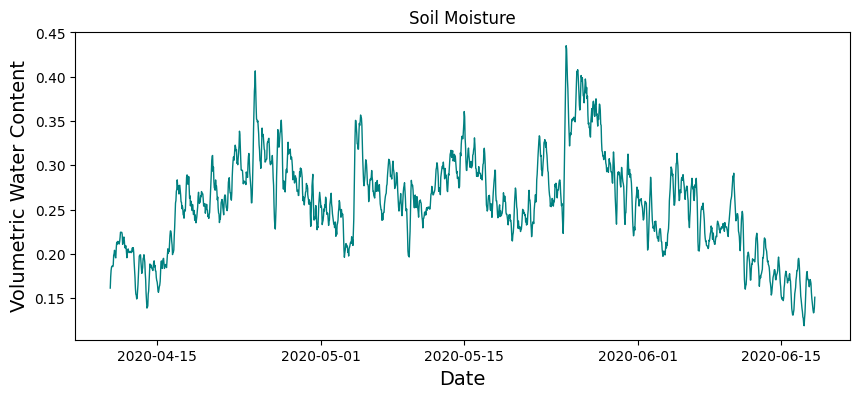

In [16]:
# Plot the obtained time series of volumetric water content
# Create a new figure and plot the data
fig, ax = plt.subplots(figsize=(10, 4))  # Set the figure size
ax.plot(df['timestamp'], df['VWC'], color='teal', linewidth=1.0)

# Set the labels for the x-axis and y-axis
ax.set_xlabel("Date", fontsize=14)
ax.set_ylabel("Volumetric Water Content", fontsize=14)

# Set the title of the plot
ax.set_title('Soil Moisture')

# Show the plot
plt.show()


### Sensing depth and soil water storage

Estimate the [`sensing_depth()`](https://soilwater.github.io/crnpy/reference/#crnpy.crnpy.sensing_depth)  at which 86 % of the neutrons probes the soil profile, and estiamte the soil water [`storage()`](https://soilwater.github.io/crnpy/reference/#crnpy.crnpy.storage) of the top 50 cm using and exponential filter.

In [17]:
# Estimate sensing depth
df['sensing_depth'] = crnpy.sensing_depth(df['VWC'], df['barometric_pressure_Avg'], df['barometric_pressure_Avg'].mean(), bulk_density=1.33, Wlat=lattice_water, method = "Franz_2012")
print(f"Average sensing depth: {np.round(df['sensing_depth'].mean(),2)} cm")


Average sensing depth: 15.36 cm


In [18]:
# Compute the storage using the exponential filter
surface = df['VWC']
subsurface = crnpy.exp_filter(df['VWC'])

z_surface = 150 # Average depth in mm obtained from previous cell using crnpy.sensing_depth()
z_subsurface = 350 # Arbitrary subsurface depth in mm
df['storage'] = np.sum([surface*z_surface, subsurface*z_subsurface], axis=0)


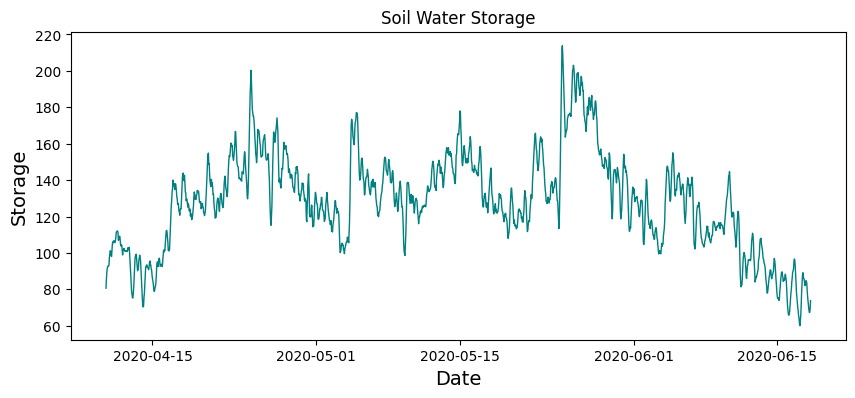

In [19]:
# Plot the obtained time series of soil water storage
# Create a new figure and plot the data
fig, ax = plt.subplots(figsize=(10, 4))  # Set the figure size
ax.plot(df['timestamp'], df['storage'], color='teal', linewidth=1.0)

# Set the labels for the x-axis and y-axis
ax.set_xlabel("Date", fontsize=14)
ax.set_ylabel("Storage", fontsize=14)

# Set the title of the plot
ax.set_title('Soil Water Storage')

# Show the plot
plt.show()


### Uncertainty estimation

Estimate the uncertainty of the volumetric water content using the [`uncertainty_vwc()`](https://soilwater.github.io/crnpy/reference/#crnpy.crnpy.uncertainty_vwc) function. Optionally see [`uncertainty_counts()`](https://soilwater.github.io/crnpy/reference/#crnpy.crnpy.uncertainty_counts) for estimating the uncertainty of the neutron counts.

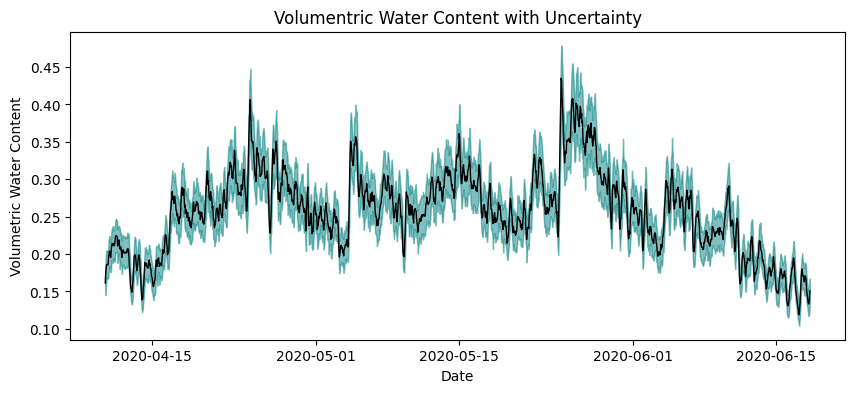

In [20]:
# Estimate the uncertainty of the volumetric water content
df['sigma_VWC'] = crnpy.uncertainty_vwc(df['total_raw_counts'], N0=N0_rdt, bulk_density=1.33, fp=df['fp'], fi=df['fi'], fw=df['fw'])

# Plot the VWC with uncertainty as a shaded area
fig, ax = plt.subplots(figsize=(10, 4))  # Set the figure size
ax.plot(df['timestamp'], df['VWC'], color='black', linewidth=1.0)
ax.fill_between(df['timestamp'], df['VWC']-df['sigma_VWC'], df['VWC']+df['sigma_VWC'], color='teal', alpha=0.5)
ax.set_title('Volumentric Water Content with Uncertainty')
ax.set_xlabel("Date")
ax.set_ylabel("Volumetric Water Content")
plt.show()
